In [1]:
import glob
import os
import json
import pickle as pkl
import yaml

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pyarrow.parquet as pq
from sklearn.metrics import auc, roc_curve
from scipy.special import softmax

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)

import utils_farouk as utils
plt.rcParams.update({"font.size": 20})

/opt/anaconda3/envs/coffea-env/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
! ls ../Apr12_presel_2017

DYJetsToLL_Pt-100To250                  SingleElectron_Run2017F
DYJetsToLL_Pt-250To400                  SingleMuon_Run2017B
DYJetsToLL_Pt-400To650                  SingleMuon_Run2017C
DYJetsToLL_Pt-50To100                   SingleMuon_Run2017D
DYJetsToLL_Pt-650ToInf                  SingleMuon_Run2017E
GluGluHToTauTau                         SingleMuon_Run2017F
GluGluHToWW_Pt-200ToInf_M-125           TTTo2L2Nu
GluGluZH_HToWW_ZTo2L_M-125              TTToHadronic
HWminusJ_HToWW_M-125                    TTToSemiLeptonic
HWplusJ_HToWW_M-125                     VBFHToWWToLNuQQ_M-125_withDipoleRecoil
HZJ_HToWW_M-125                         WJetsToLNu_HT-100To200
QCD_Pt_1000to1400                       WJetsToLNu_HT-1200To2500
QCD_Pt_1400to1800                       WJetsToLNu_HT-200To400
QCD_Pt_170to300                         WJetsToLNu_HT-2500ToInf
QCD_Pt_1800to2400                       WJetsToLNu_HT-400To600
QCD_Pt_2400to3200                       WJetsToLNu_HT-600To800
QCD_Pt_300to470 

# Read cutflows from pkl

In [183]:
combine_samples = {
    # data
    # "SingleElectron_": "SingleElectron",
    "SingleElectron_": "Data",
    # "SingleMuon_": "SingleMuon_",
    "SingleMuon_": "Data",
    # "EGamma_": "EGamma",
    "EGamma_": "Data",
    # signal
    "GluGluHToWW_Pt-200ToInf_M-125": "HWW",
    "HToWW_M-125": "VH",
    "VBFHToWWToLNuQQ_M-125_withDipoleRecoil": "VBF",
    "ttHToNonbb_M125": "ttH",
    # bkg
    "QCD_Pt": "QCD",
    "DYJets": "DYJets",
    "WJetsToLNu_": "WJetsLNu",
    "JetsToQQ": "WZQQ",
    "TT": "TTbar",
    "ST_": "SingleTop",
    "WW": "Diboson",
    "WZ": "Diboson",
    "ZZ": "Diboson",
}

def get_sum_sumgenweight(pkl_files, year, sample):
    sum_sumgenweight = 0
    for ifile in pkl_files:
        # load and sum the sumgenweight of each
        with open(ifile, "rb") as f:
            metadata = pkl.load(f)
        sum_sumgenweight = sum_sumgenweight + metadata[sample][year]["sumgenweight"]
    return sum_sumgenweight


def get_xsecweight(pkl_files, year, sample, is_data, luminosity):
    if not is_data:
        # find xsection
        f = open("../fileset/xsec_pfnano.json")
        xsec = json.load(f)
        f.close()
        try:
            xsec = eval(str((xsec[sample])))
        except ValueError:
            print(f"sample {sample} doesn't have xsecs defined in xsec_pfnano.json so will skip it")
            return None

        # get overall weighting of events.. each event has a genweight...
        # sumgenweight sums over events in a chunk... sum_sumgenweight sums over chunks
        xsec_weight = (xsec * luminosity) / get_sum_sumgenweight(pkl_files, year, sample)
    else:
        xsec_weight = 1
    return xsec_weight

def get_cutflow(pkl_files, year, sample, weight, ch):
    """
    Get cutflow from metadata but multiply by xsec-weight
    """
    cuts = {}
    cuts["mu"] = ["trigger", 
            "metfilters", 
            "leptonKin", 
            "fatjetKin", 
            "ht", 
            "oneLepton", 
            "notaus", 
            "leptonInJet", 
            "lep_isolation", 
            "lep_misolation"
           ]
    cuts["ele"] = cuts["mu"][:-1]  # remove lep_misolation
    
    evyield = dict.fromkeys(cuts[ch], 0)
    for ik, pkl_file in enumerate(pkl_files):
        with open(pkl_file, "rb") as f:
            metadata = pkl.load(f)
            if ch == "lep":
                cutflows = metadata[sample][year]["cutflows"]
            else:
                cutflows = metadata[sample][year]["cutflows"][ch]

            for key in evyield.keys():
                evyield[key] += cutflows[key] * weight
    return evyield

In [184]:
channels = ["mu", "ele"]

samples = [
    "HWW", 
    "VH",
    "VBF",
    "ttH",
    "QCD",
    "DYJets",
    "WJetsLNu",
    "WZQQ",
    "TTbar",
    "SingleTop",
    "Diboson",
]

In [186]:
# years = ["2018", "2017", "2016", "2016APV"]
years = ["2017"]

cutflows = {}
for year in years:
    print(f"Processing year {year}")    
    samples_dir = f"../Apr12_presel_{year}"

    cutflows[year] = {}
    
    for ch in channels:
        cutflows[year][ch] = {}

        # get lumi
        with open("../fileset/luminosity.json") as f:
            luminosity = json.load(f)[ch][year]

        condor_dir = os.listdir(samples_dir)

        for sample in condor_dir:

            # get a combined label to combine samples of the same process
            for key in combine_samples:
                if key in sample:
                    sample_to_use = combine_samples[key]
                    break
                else:
                    sample_to_use = sample

            if sample_to_use not in samples:
                continue

            is_data = False
            # if sample_to_use == data_by_ch[ch]:
            if sample_to_use == "Data":
                is_data = True

            print(f"Finding {sample} samples and should combine them under {sample_to_use}")

            out_files = f"{samples_dir}/{sample}/outfiles/"
            pkl_files = glob.glob(f"{out_files}/*.pkl")

            xsec_weight = get_xsecweight(pkl_files, year, sample, is_data, luminosity)
            if sample_to_use not in cutflows[year][ch].keys():
                cutflows[year][ch][sample_to_use] = get_cutflow(pkl_files, year, sample, xsec_weight, ch)
            else:
                temp = get_cutflow(pkl_files, year, sample, xsec_weight, ch)
                for key in cutflows[year][ch][sample_to_use]:
                    cutflows[year][ch][sample_to_use][key] += temp[key]
                    
        print(f"------------------------------------------")                    

Processing year 2017
Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
Finding DYJetsToLL_Pt-400To650 samples and should combine them under DYJets
Finding VBFHToWWToLNuQQ_M-125_withDipoleRecoil samples and should combine them under VBF
Finding HWminusJ_HToWW_M-125 samples and should combine them under VH
Finding WJetsToLNu_HT-800To1200 samples and should combine them under WJetsLNu
Finding TTToSemiLeptonic samples and should combine them under TTbar
Finding DYJetsToLL_Pt-250To400 samples and should combine them under DYJets
Finding ST_t-channel_top_4f_InclusiveDecays samples and should combine them under SingleTop
Finding ST_s-channel_4f_hadronicDecays samples and should combine them under SingleTop
Finding WJetsToLNu_HT-1200To2500 samples and should combine them under WJetsLNu
Finding WJetsToLNu_HT-200To400 samples and should combine them under WJetsLNu
Finding ST_tW_top_5f_inclusiveDecays samples and should combine them under SingleTop
Finding GluGluHToWW_

In [187]:
cutflows.keys()

dict_keys(['2017'])

In [188]:
cutflows["2018"].keys()

KeyError: '2018'

In [189]:
cutflows["2018"]["mu"].keys()

KeyError: '2018'

# Combine different channels

In [190]:
# combine both channels
cutflows_new = {}
for year in years:
    cutflows_new[year] = {}
    for ch in cutflows[year]:
        for sample in cutflows[year][ch]:
            if sample not in cutflows_new[year]:
                cutflows_new[year][sample] = {}

            for cut in cutflows[year][ch][sample]:
                if cut not in cutflows_new[year][sample]:
                    cutflows_new[year][sample][cut] = cutflows[year][ch][sample][cut]
                else:
                    cutflows_new[year][sample][cut] += cutflows[year][ch][sample][cut]
                    
cutflows = cutflows_new

In [191]:
cutflows.keys()

dict_keys(['2017'])

In [192]:
cutflows["2017"].keys()

dict_keys(['WJetsLNu', 'DYJets', 'VBF', 'VH', 'TTbar', 'SingleTop', 'HWW', 'WZQQ', 'QCD', 'Diboson', 'ttH'])

# Combine different years

In [194]:
# combine all years
cutflows_new = {}
for year in cutflows:
    for sample in cutflows[year]:
        if sample not in cutflows_new:
            cutflows_new[sample] = {}

        for cut in cutflows[year][sample]:
            if cut not in cutflows_new[sample]:
                cutflows_new[sample][cut] = cutflows[year][sample][cut]
            else:
                cutflows_new[sample][cut] += cutflows[year][sample][cut]
                
cutflows = cutflows_new

In [195]:
cutflows.keys()

dict_keys(['WJetsLNu', 'DYJets', 'VBF', 'VH', 'TTbar', 'SingleTop', 'HWW', 'WZQQ', 'QCD', 'Diboson', 'ttH'])

In [196]:
cutflows["TTbar"]

{'trigger': 44406.19581542611,
 'metfilters': 44376.860132490074,
 'leptonKin': 38285.82694127156,
 'fatjetKin': 6758.744550768859,
 'ht': 6747.430856943642,
 'oneLepton': 4637.452848444562,
 'notaus': 3648.295680557382,
 'leptonInJet': 1585.1771898799802,
 'lep_isolation': 1555.6074095649021,
 'lep_misolation': 715.979000547815}

# Plot cutflows

In [67]:
plt.rcParams.update({"font.size": 20})

In [85]:
lumi = 0
for year in years:
    # get lumi
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lumi += json.load(f)[ch][year] 
            
if len(channels)==2:
    lumi /= 2

In [126]:
cut_to_label = {
    "trigger": "Trigger",
    "metfilters": "Metfilters", 
    "leptonKin": "Lepton kinematics", 
    "fatjetKin": "Jet kinematics", 
    "ht": "Hadronic activity", 
    "oneLepton": "One Lepton", 
    "notaus": "No Taus", 
    "leptonInJet": "Lepton inside Jet", 
    "lep_isolation": "Lepton isolation", 
    "lep_misolation": "Lepton mini-isolation" 
}

# plot histograms
color_by_sample = {
    "HWW": "red",
    "VH": "tab:brown",
    "VBF": "tab:gray",
    "ttH": "tab:olive",
    
    "DYJets": "tab:purple",
    "QCD": "tab:orange",
    "TTbar": "tab:blue",
    "WJetsLNu": "tab:green",
    "Others": "tab:grey", 

    "Diboson": "orchid",    
    "WZQQ": "salmon",
    "SingleTop": "tab:cyan",
    
#     "WplusHToTauTau": "tab:cyan",
#     "WminusHToTauTau": "tab:cyan",
#     "ttHToTauTau": "tab:cyan",
#     "GluGluHToTauTau": "tab:cyan",
#     "ZHToTauTau": "tab:cyan",
#     "VBFHToTauTau": "tab:cyan",
}

In [177]:
# combine non-dominant backgrounds under others
dominant_bkgs = ["QCD", "WJetsLNu", "TTbar", "DYJets"]
signals = ["HWW", "VH", "VBF", "ttH"]

cutflows["Others"] = dict.fromkeys(cutflows["HWW"], 0)
for sample in cutflows:
    if sample not in signals+dominant_bkgs:
        for cut in cutflows[sample]:
            cutflows["Others"][cut] += cutflows[sample][cut]

In [180]:
# debugging
tot = {}
for sample in cutflows:
    tot[sample] = 0
    for cut in cutflows[sample]:
        tot[sample] += cutflows[sample][cut]
        
tot        

{'WJetsLNu': 370702176.1274254,
 'DYJets': 1065789.9387852189,
 'VBF': 9092.770948413594,
 'VH': 66284.92181099442,
 'TTbar': 521678.1858902939,
 'SingleTop': 384220.47460363846,
 'HWW': 43620.698685998395,
 'WZQQ': 4645469.406106534,
 'QCD': 551949467.598598,
 'Diboson': 8275002.32643416,
 'ttH': 88369.80097372716,
 'Others': 26609384.414288666}

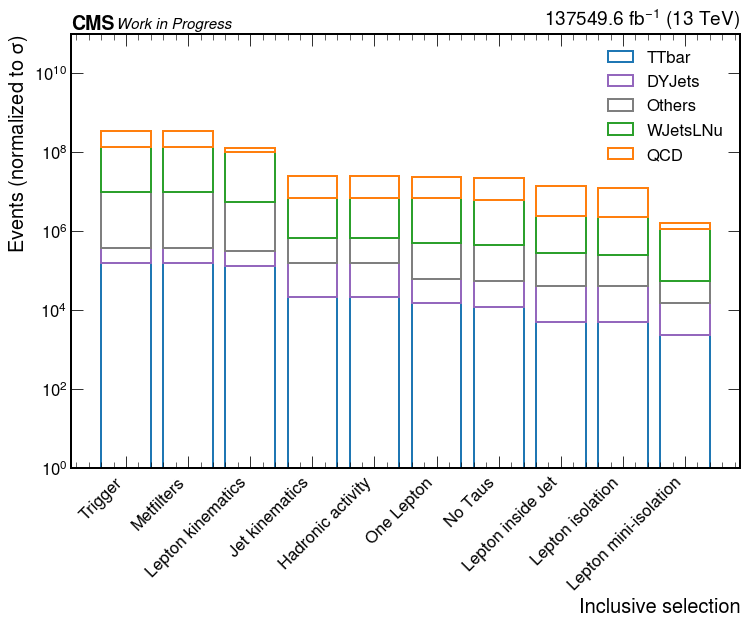

In [182]:
samples = [
#     "HWW", 
#     "VH",
#     "VBF",
#     "ttH",
    "QCD",
    "DYJets",
    "WJetsLNu",
#     "WZQQ",
    "TTbar",
#     "SingleTop",
#     "Diboson",
    "Others"
]

labels = list(cutflows[samples[0]].keys())  
values = [[cutflows[sample][label] for label in labels] for sample in samples]
for i, lab in enumerate(labels):
    labels[i] = cut_to_label[lab]

# Sort the samples by yield
sorted_idx = sorted(range(len(values)), key=lambda i: sum(values[i]), reverse=False)
samples = [samples[i] for i in sorted_idx]
values = [values[i] for i in sorted_idx]

fig, ax = plt.subplots(figsize=(12, 8))
# Plot the cutflows as a stacked bar chart for each sample
bottom = [0] * len(labels)
for i, sample in enumerate(samples):
    if all(v == 0 for v in values[i]):
        print(f"Sample {sample} is empty")
        continue    
    ax.bar(labels, values[i], bottom=bottom, label=sample, edgecolor=color_by_sample[sample], linewidth=2, fill=False)
    bottom = [sum(x) for x in zip(bottom, values[i])]
    
# ax.legend(title="Semi-leptonic channel")
ax.legend()

plt.xticks(rotation=45, ha='right')
ax.set_xlabel('Inclusive selection')
ax.set_ylabel(r'Events (normalized to $\sigma$)')
ax.set_yscale("log")
ax.set_ylim(1,10**11)
 
hep.cms.lumitext(
    "%.1f " % lumi + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20
)
hep.cms.text("Work in Progress", ax=ax, fontsize=15);

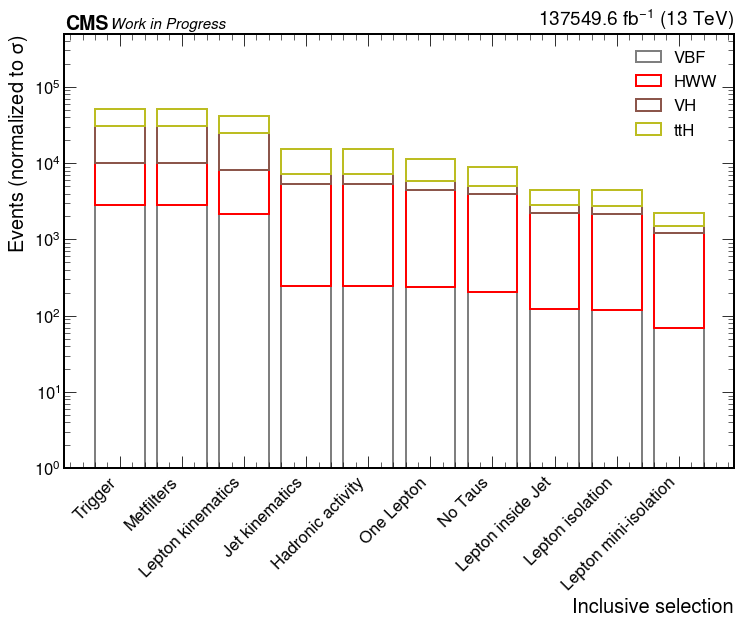

In [148]:
# for signal
samples = [
    "HWW", 
    "VH",
    "VBF",
    "ttH",
#     "QCD",
#     "DYJets",
#     "WJetsLNu",
#     "WZQQ",
#     "TTbar",
#     "SingleTop",
#     "Diboson",
#     "Data"
]

colors = ['blue', 'green', 'red', 'orange']

labels = list(cutflows[samples[0]].keys())
values = [[cutflows[sample][label] for label in labels] for sample in samples]

for i, lab in enumerate(labels):
    labels[i] = cut_to_label[lab]

# Sort the samples by yield
sorted_idx = sorted(range(len(values)), key=lambda i: sum(values[i]), reverse=False)
samples = [samples[i] for i in sorted_idx]
values = [values[i] for i in sorted_idx]

fig, ax = plt.subplots(figsize=(12, 8))
# Plot the cutflows as a stacked bar chart for each sample
bottom = [0] * len(labels)
for i, sample in enumerate(samples):
    if all(v == 0 for v in values[i]):
        print(f"Sample {sample} is empty")
        continue    
    ax.bar(labels, values[i], bottom=bottom, label=sample, edgecolor=color_by_sample[sample], linewidth=2, fill=False)
    bottom = [sum(x) for x in zip(bottom, values[i])]
    
plt.xticks(rotation=45, ha='right')

# ax.legend(title="Semi-leptonic channel")
ax.legend()

plt.xticks(rotation=45, ha='right')
ax.set_xlabel('Inclusive selection')
ax.set_ylabel(r'Events (normalized to $\sigma$)')
ax.set_yscale("log")
ax.set_ylim(1,5*10**5)
 
hep.cms.lumitext(
    "%.1f " % lumi + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20
)
hep.cms.text("Work in Progress", ax=ax, fontsize=15);